In [1]:
%cd ../..

/home/work/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data

from combinators.inference import conditioning, variational
from combinators.lens import Cap, PRO, Ty
from combinators.model import collections
from combinators import sampler, signal, utils


In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = 3
batch_shape = (num_particles,)

In [8]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [9]:
def accumulate_trajectory(p):
    initial_position = p['position_0'].value
    initial_velocity = p['velocity_0'].value
    velocities = torch.zeros(initial_velocity.shape[0], T + 1, 2)
    velocities[:, 0] = initial_velocity
    for t in range(1, T + 1):
        velocities[:, t] = p['velocity_%d' % t].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T, velocities=velocities)
    return trajectory[:, :, 0, :]

In [10]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [11]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [12]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [13]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [14]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [15]:
def training_model():
    init_dynamics = dynamical_ball.InitBallDynamics()
    update = dynamical_ball.InitDynamicsProposal()
    init_dynamics = sampler.importance_box('init_dynamics', init_dynamics,
                                           batch_shape, update, PRO(0), PRO(2))
    init_state = dynamical_ball.InitialBallState()
    update = dynamical_ball.InitBallProposal()
    init_state = sampler.importance_box('init_state', init_state, batch_shape,
                                        update, PRO(0), PRO(2))
    
    step = dynamical_ball.StepBallState()
    update = dynamical_ball.StepBallProposal()
    step = sampler.importance_box('step_state', step, batch_shape, update, PRO(4), PRO(2))
    step = collections.parameterized_ssm(PRO(2), PRO(2), step)
    
    return (init_state @ init_dynamics) >> collections.sequential(step, T)

02/20/2022 10:50:59 elbo=-8.24811462e+02 at epoch 1
02/20/2022 10:51:01 elbo=-7.55445862e+02 at epoch 2
02/20/2022 10:51:02 elbo=-1.93365137e+03 at epoch 3
02/20/2022 10:51:04 elbo=-5.18711670e+02 at epoch 4
02/20/2022 10:51:05 elbo=-5.93850037e+02 at epoch 5
02/20/2022 10:51:07 elbo=-4.81809204e+02 at epoch 6
02/20/2022 10:51:08 elbo=-5.50864014e+02 at epoch 7
02/20/2022 10:51:10 elbo=-5.33579163e+02 at epoch 8
02/20/2022 10:51:11 elbo=-5.03660309e+02 at epoch 9
02/20/2022 10:51:13 elbo=-7.55414368e+02 at epoch 10
02/20/2022 10:51:15 elbo=-3.86062653e+02 at epoch 11
02/20/2022 10:51:17 elbo=-4.47437592e+02 at epoch 12
02/20/2022 10:51:18 elbo=-4.23273346e+02 at epoch 13
02/20/2022 10:51:19 elbo=-4.62093506e+02 at epoch 14
02/20/2022 10:51:21 elbo=-4.81541412e+02 at epoch 15
02/20/2022 10:51:22 elbo=-4.13091339e+02 at epoch 16
02/20/2022 10:51:24 elbo=-3.87802826e+02 at epoch 17
02/20/2022 10:51:25 elbo=-4.20725708e+02 at epoch 18
02/20/2022 10:51:27 elbo=-3.62070099e+02 at epoch 19
02

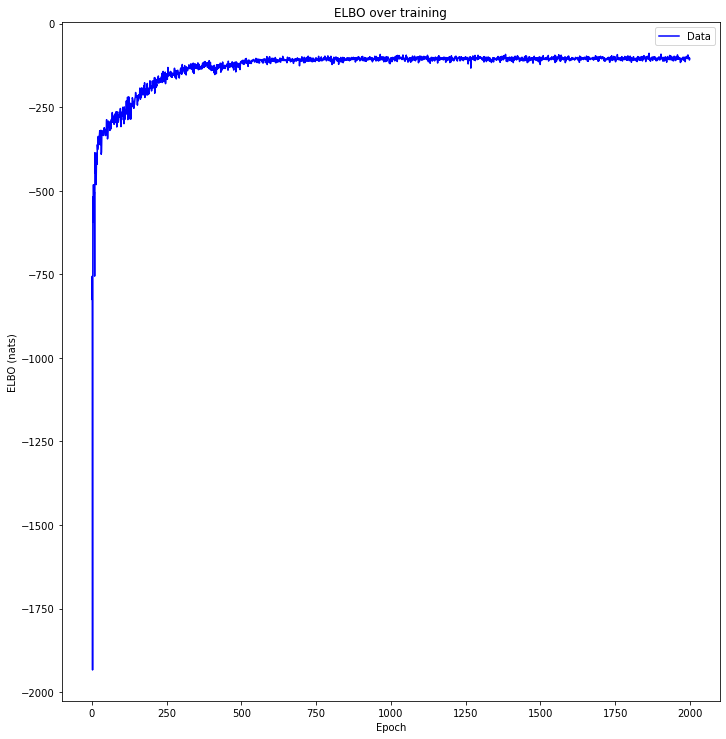

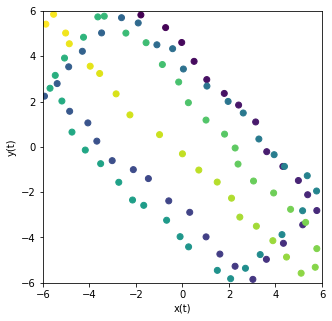

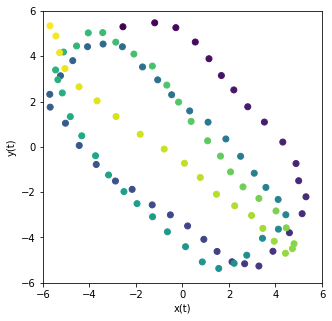

In [16]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)
    data_dicts = [data['position_%d' % t].detach() for t in range(T)]

    diagram = training_model()
    diagram = conditioning.SequentialConditioner(step_state=data_dicts)(diagram)
    elbos = variational.infer(diagram, 2000, use_cuda=True, lr=1e-2, patience=100)
    
    utils.plot_evidence_bounds(elbos.detach().numpy(), True)
    
    graph = sampler.compile(diagram >> signal.Cap(diagram.cod))
    sampler.filter(graph)
    sampler.smooth(graph)
    p, log_weight = sampler.trace(graph)
    inferred_trajectory = accumulate_trajectory(p)

    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([p['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [17]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])
    print('Inferred position at time %d' % t, positions[t])
    print('MSE at time %d' % t, ((data['position_%d' % t] - positions[t])**2).sum())

Position at time 0 tensor([-1.7876,  5.8258])
Inferred position at time 0 tensor([-2.5595,  5.3037])
MSE at time 0 tensor(0.8685)
Position at time 1 tensor([-0.7244,  5.2673])
Inferred position at time 1 tensor([-1.1937,  5.4782])
MSE at time 1 tensor(0.2647)
Position at time 2 tensor([-0.0314,  4.6101])
Inferred position at time 2 tensor([-0.2840,  5.2651])
MSE at time 2 tensor(0.4928)
Position at time 3 tensor([0.5010, 3.7770])
Inferred position at time 3 tensor([0.5517, 4.6309])
MSE at time 3 tensor(0.7317)
Position at time 4 tensor([1.0461, 2.9720])
Inferred position at time 4 tensor([1.1409, 3.8931])
MSE at time 4 tensor(0.8574)
Position at time 5 tensor([1.7991, 2.3608])
Inferred position at time 5 tensor([1.6742, 3.1507])
MSE at time 5 tensor(0.6396)
Position at time 6 tensor([2.4158, 1.8475])
Inferred position at time 6 tensor([2.2105, 2.5151])
MSE at time 6 tensor(0.4878)
Position at time 7 tensor([3.1485, 1.1015])
Inferred position at time 7 tensor([2.8089, 1.7723])
MSE at ti